In [200]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os, re, glob, parse
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('muted')

ligan_root = 'C:\\Users\mtr22\Code\liGAN'
sys.path.append(ligan_root)
import results

print('SSHFS status\n------------')
print('Bridges {}'.format(os.path.exists('E:\\')))
print('CSB     {}'.format(os.path.exists('D:\\')))
print('CRC     {}'.format(os.path.exists('F:\\')))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
SSHFS status
------------
Bridges False
CSB     False
CRC     False


# train.py

In [ ]:
def read_err_file(err_file):
    error = None
    with open(err_file, encoding='utf-8') as f:
        for line in f:
            if not re.match('Warning.*', line) \
               and re.match(r'.*(Error|Exception|error|fault|failed).*', line):
                error = line.rstrip()
    return error

indent = 4*' '
train_output_files = []
for expt_dir in ['E:\\pylon5\\mc5phpp\\mtragoza\\liGAN\\train_molport\\loss_types']:
    
    for job_name in ['ae_disc_x_0', 'gen_e_disc_x_0']:
        
        job_dir = os.path.join(expt_dir, job_name)
        
        err_files = []
        for err_file in os.listdir(job_dir):

            m = re.match(r'slurm-(\d+)\.err', err_file)
            if not m:
                continue
            
            job_id = int(m.group(1))
            err_file = os.path.join(job_dir, err_file)
            error = read_err_file(err_file)
            err_files.append((job_id, err_file, error))
            
        for job_id, err_file, error in sorted(err_files):
            print(err_file + '\t' + str(error)[:72])
        
            try:
                train_output_file_pat = os.path.join(job_dir, str(job_id), '*.training_output')
                train_output_file = glob.glob(train_output_file_pat)[0]
                train_output_files.append(train_output_file)
            except IndexError:
                pass
            
        print()

len(train_output_files)

In [ ]:
vae_name_format = 'gen_{gen_loss_type}_disc_{disc_loss_type}_{random_seed}'
ae_name_format  = 'ae_disc_{disc_loss_type}_{random_seed}'

train_job_dfs = []
for train_output_file in train_output_files:
    try:
        train_job_df = pd.read_csv(train_output_file, sep=' ')
        print(train_output_file)
    except Exception as e:
        print(train_output_file, e, file=sys.stderr)
        continue
    
    scr_dir = os.path.dirname(train_output_file)
    job_dir, job_id = os.path.split(scr_dir)
    expt_dir, job_name = os.path.split(job_dir)
    _, expt_name = os.path.split(expt_dir)

    out_file = '/'.join([expt_name, job_name, 'slurm-{}.out'.format(job_id)])
    err_file = '/'.join([expt_name, job_name, 'slurm-{}.err'.format(job_id)])
    
    train_job_df['expt_name'] = expt_name
    train_job_df['job_name'] = job_name
    train_job_df['model_name'] = job_name.rsplit('_', 1)[0]
    train_job_df['job_id'] = int(job_id)
    train_job_df['out_file'] = out_file
    train_job_df['err_file'] = err_file
    
    # get params from job_name
    try:
        job_params = parse.parse(vae_name_format, job_name).named
        variational = True
    except:
        job_params = parse.parse(ae_name_format, job_name).named
        variational = False
        
    train_job_df['variational'] = variational
    if not variational:
        train_job_df['gen_loss_type'] = 'e'
    
    for param, value in job_params.items():
        train_job_df[param] = value
    
    # get error from err_file
    #train_job_df['job_error'] = read_err_file(err_file)
    
    train_job_df = train_job_df.rename(columns=dict({'test_data': 'phase'}))
    
    train_job_dfs.append(train_job_df)

train_df = pd.concat(train_job_dfs)
train_df.set_index(['expt_name', 'job_name', 'job_id'])

In [ ]:
def second_min(x):
    try:
        return x.sort_values().iloc[1]
    except IndexError:
        return np.nan

train_df[train_df['phase'] == 'train'].groupby(['job_name', 'job_id'])[['iteration']].agg([min, second_min, max])

In [ ]:
train_df.groupby(['job_name', 'iteration', 'phase'])[['job_id']].agg(['count', min, max])

In [ ]:
agg_train_df = train_df.reset_index()
agg_train_df = agg_train_df.loc[agg_train_df.groupby(['job_name', 'iteration', 'phase'])['job_id'].idxmax()]
agg_train_df.groupby(['job_name', 'iteration', 'phase'])[['job_id']].agg(['count', min, max])

In [ ]:
from collections import OrderedDict
from results import plot_lines

plot_df = agg_train_df[(agg_train_df['phase'] == 'test') &
                       (agg_train_df['iteration'] <= 200000)].copy()

k = 5000
plot_df['Iteration'] = (plot_df['iteration']//k)*k

plot_df['Gen. L2 loss']      = plot_df['gen_L2_loss']
plot_df['Gen. adv. loss']    = plot_df['gen_adv_log_loss']
plot_df['Disc. loss']        = plot_df['disc_log_loss']
plot_df['Gen. KL-div. loss'] = plot_df['gen_kldiv_loss']

plot_df['Method'] = plot_df['variational'].map(lambda x: ('AE', 'VAE')[x])

x = 'Iteration'
y = [
    'Gen. L2 loss',
    'Gen. adv. loss',
    'Disc. loss',
    'Gen. KL-div. loss',
]
hue = 'Method'
hue_order = method_order

fig = plot_lines('train_loss.png', plot_df, x=x, y=y, hue=hue, hue_order=hue_order, colors=colors[1:3],
                 n_cols=4, height=3, width=3, alpha=0.5, despine=True)

# generate.py

In [3]:
fit_expt_files = [
    #'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\metrics\\csb_molport2.gen_metrics',
    #'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\metrics\\crc_pubchem2.gen_metrics',
    #'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\metrics\\bridges_pubchem2.gen_metrics',
    #'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\metrics\\crc_molport3.gen_metrics',
    
    #'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\loss_weights\\crc_fit_molport2.gen_metrics',
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\loss_weights\\csb_fit_molport2.gen_metrics',
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\loss_weights\\csb_fit_pubchem2.gen_metrics',
    
    #'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\loss_weights\\csb_fit_molport2_dkoes.gen_metrics',
]

val_expt_files = [
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\loss_weights\\csb_fit_molport2_validify.gen_metrics',
    'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\loss_weights\\csb_fit_pubchem2_validify.gen_metrics',
]

expt_param_names = ['expt_name', 'cluster', 'fit_type']
fit_expt_name_format = '{cluster}_fit_{dataset}2'
val_expt_name_format = '{cluster}_fit_{dataset}2_validify'

fit_expt_dfs = []
for expt_file in fit_expt_files:
    print(expt_file)
    expt_df = pd.read_csv(expt_file, sep=' ')
    expt_name = os.path.splitext(os.path.basename(expt_file))[0]
    if expt_name.endswith('_dkoes'):
        fit_type = 'dkoes'
        expt_name = expt_name.rsplit('_', 1)[0]
    else:
        fit_type = 'default'
    expt_params = parse.parse(fit_expt_name_format, expt_name).named
    
    expt_df['expt_name'] = expt_name
    expt_df['expt_type'] = 'generate'
    expt_df['cluster'] = expt_params['cluster']
    expt_df['fit_type'] = fit_type
    #expt_df['dataset'] = expt_params['dataset'] # duplicate column
    fit_expt_dfs.append(expt_df)
    
val_expt_dfs = []
for expt_file in val_expt_files:
    print(expt_file)
    expt_df = pd.read_csv(expt_file, sep=' ')
    expt_name = os.path.splitext(os.path.basename(expt_file))[0]
    expt_params = parse.parse(val_expt_name_format, expt_name).named

    expt_df['expt_name'] = expt_name
    expt_df['expt_type'] = 'validify'
    expt_df['cluster'] = expt_params['cluster']
    #expt_df['dataset'] = expt_params['dataset'] # duplicate column
    val_expt_dfs.append(expt_df)
    
fit_df = pd.concat(fit_expt_dfs)
val_df = pd.concat(val_expt_dfs)

C:\Users\mtr22\Code\liGAN\train_molport\loss_weights\csb_fit_molport2.gen_metrics
C:\Users\mtr22\Code\liGAN\train_molport\loss_weights\csb_fit_pubchem2.gen_metrics


c:\users\mtr22\code\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (32,60) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


C:\Users\mtr22\Code\liGAN\train_molport\loss_weights\csb_fit_molport2_validify.gen_metrics


c:\users\mtr22\code\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,73,75,77) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


C:\Users\mtr22\Code\liGAN\train_molport\loss_weights\csb_fit_pubchem2_validify.gen_metrics


c:\users\mtr22\code\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (15,19,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
from functools import lru_cache

job_param_names = [
    'job_name', 'variational', 'gen_loss_type', 'KL_loss_weight', 'L2_loss_weight',
    'disc_loss_type', 'GAN_loss_weight', 'random_seed', 'train_job_name', 'loss_weights',
    'iteration', 'prior', 'data_name', 'molport_sim', 'AE/VAE', 'posterior/prior',
    'dataset', 'gen_method', 'validify', 'val_options', 'dkoes_make_mol', 'use_openbabel', 'valid_mode',
]

job_name_formats = {
    'AE_molport': 'ae_disc_{disc_loss_type}_{random_seed}_{iteration}_{fit_options}',
    'AE_pubchem': 'ae_disc_{disc_loss_type}_{random_seed}_{iteration}_{fit_options}_pubchem_diff{molport_sim:f}',
    'VAE_molport': 'gen_{gen_loss_type}_{KL_loss_weight}_{L2_loss_weight}_disc_{disc_loss_type}_{GAN_loss_weight}' \
        '_{random_seed}_{iteration}_{fit_options}',
    'VAE_pubchem': 'gen_{gen_loss_type}_{KL_loss_weight}_{L2_loss_weight}_disc_{disc_loss_type}_{GAN_loss_weight}' \
        '_{random_seed}_{iteration}_{fit_options}_pubchem_diff{molport_sim:f}',
}

@lru_cache(100)
def parse_job_name(job_name, validify):
    
    variational = job_name.startswith('gen_')
    is_pubchem = 'pubchem' in job_name

    # get correct format for parsing job name
    if variational:
        if is_pubchem:
            job_name_format = job_name_formats['VAE_pubchem']
        else:
            job_name_format = job_name_formats['VAE_molport']
    else:
        if is_pubchem:
            job_name_format = job_name_formats['AE_pubchem']
        else:
            job_name_format = job_name_formats['AE_molport']
            
    # parse job name to get job params
    print(job_name)
    if validify: 
        if is_pubchem:
            val_job_name_format = job_name_format + '_{val_options}'
        else:
            val_job_name_format = job_name_format + '_molportFULL_rand_test0_{val_options}'
        val_job_name = job_name + 'x'

        job_params = parse.parse(val_job_name_format, val_job_name).named
        job_name = val_job_name.rsplit('_', 1)[0]
        job_params['val_options'] = job_params['val_options'].rstrip('x')
    else:
        
        job_params = parse.parse(job_name_format, job_name).named
        job_params['val_options'] = ''
    
    job_params['job_name'] = job_name
    
    if variational:
        job_params['AE/VAE'] = 'VAE'
    else:
        job_params['AE/VAE'] = 'AE'
    
    job_params['validify'] = validify
    
    if is_pubchem:
        job_params['dataset'] = 'pubchem'
        job_params['data_name'] = 'pubchem_diff' + str(job_params['molport_sim'])
    else:
        job_params['dataset'] = 'molport'
        job_params['data_name'] = 'molportFULL_rand_test0'
        job_params['molport_sim'] = 1.1 # this just to make plotting look nice, not a real value...
    
    job_params['variational'] = variational
    
    if not variational:
        job_params['gen_loss_type'] = 'e'
    
    # parse fit_options and val_options flags into new boolean params
    fit_options = job_params['fit_options']
    job_params['prior'] = 'p' in fit_options
    job_params['random_rotation'] = 'r' in fit_options
    job_params['dkoes_simple_fit'] = 'd' in fit_options
    job_params['dkoes_make_mol'] = 'D' in fit_options
    
    val_options = job_params['val_options']
    job_params['dkoes_make_mol'] = 'D' in val_options
    job_params['use_openbabel'] = 'o' in val_options
    job_params['valid_mode'] = 'dkoes' if 'D' in val_options else 'openbabel' if 'o' in val_options else 'default'
    
    train_job_name_format = job_name_format.split('_{iteration}_')[0]
    job_params['train_job_name'] = train_job_name_format.format(**job_params)
    
    # convert data types of numeric params
    if variational:
        job_params['KL_loss_weight'] = float(job_params['KL_loss_weight'])
        job_params['L2_loss_weight'] = float(job_params['L2_loss_weight'])
        job_params['GAN_loss_weight'] = float(job_params['GAN_loss_weight'])
    else:
        job_params['KL_loss_weight'] = 1.0
        job_params['L2_loss_weight'] = 1.0
        job_params['GAN_loss_weight'] = 1.0
    
    job_params['iteration'] = int(job_params['iteration'])
    job_params['random_seed'] = int(job_params['random_seed'])
    
    # add other params
    job_params['AE/VAE'] = 'VAE' if job_params['variational'] else 'AE'
    job_params['posterior/prior'] = 'prior' if job_params['prior'] else 'posterior'
    job_params['gen_method'] = '_'.join([job_params['AE/VAE'],
                                         job_params['posterior/prior']])
    job_params['loss_weights'] = str((job_params['KL_loss_weight'],
                                      job_params['L2_loss_weight'],
                                      job_params['GAN_loss_weight']))

    return pd.Series([job_params[p] for p in job_param_names])

fit_df[job_param_names] = fit_df['job_name'].apply(parse_job_name, validify=False)
val_df[job_param_names] = val_df['job_name'].apply(parse_job_name, validify=True)

def dtype(series):
    return series.dtype

param_names = job_param_names + expt_param_names

fit_df[param_names + ['lig_name']].agg([dtype, pd.Series.nunique, pd.Series.unique]).transpose()

ae_disc_x_0_10000_r
ae_disc_x_0_20000_r
ae_disc_x_0_30000_r
ae_disc_x_0_40000_r
ae_disc_x_0_50000_r
ae_disc_x_0_60000_r
ae_disc_x_0_70000_r
ae_disc_x_0_80000_r
ae_disc_x_0_90000_r
ae_disc_x_0_100000_r
gen_e_0.1_1_disc_x_10_0_10000_r
gen_e_0.1_1_disc_x_10_0_20000_r
gen_e_0.1_1_disc_x_10_0_30000_r
gen_e_0.1_1_disc_x_10_0_40000_r
gen_e_0.1_1_disc_x_10_0_50000_r
gen_e_0.1_1_disc_x_10_0_60000_r
gen_e_0.1_1_disc_x_10_0_70000_r
gen_e_0.1_1_disc_x_10_0_80000_r
gen_e_0.1_1_disc_x_10_0_90000_r
gen_e_0.1_1_disc_x_10_0_100000_r
gen_e_0.1_1_disc_x_10_0_10000_pr
gen_e_0.1_1_disc_x_10_0_20000_pr
gen_e_0.1_1_disc_x_10_0_30000_pr
gen_e_0.1_1_disc_x_10_0_40000_pr
gen_e_0.1_1_disc_x_10_0_50000_pr
gen_e_0.1_1_disc_x_10_0_60000_pr
gen_e_0.1_1_disc_x_10_0_70000_pr
gen_e_0.1_1_disc_x_10_0_80000_pr
gen_e_0.1_1_disc_x_10_0_90000_pr
gen_e_0.1_1_disc_x_10_0_100000_pr
gen_e_0.1_1_disc_x_10_0_100000_pr_pubchem_diff0.0
gen_e_0.1_1_disc_x_10_0_100000_pr_pubchem_diff0.1
gen_e_0.1_1_disc_x_10_0_100000_pr_pubchem_diff0

,dtype,nunique,unique
job_name,object,63,"[ae_disc_x_0_10000_r, ae_disc_x_0_20000_r, ae_..."
variational,bool,2,"[False, True]"
gen_loss_type,object,1,[e]
KL_loss_weight,float64,2,"[1.0, 0.1]"
L2_loss_weight,float64,1,[1.0]
disc_loss_type,object,1,[x]
GAN_loss_weight,float64,2,"[1.0, 10.0]"
random_seed,int64,1,[0]
train_job_name,object,2,"[ae_disc_x_0, gen_e_0.1_1_disc_x_10_0]"
loss_weights,object,2,"[(1.0, 1.0, 1.0), (0.1, 1.0, 10.0)]"


In [5]:
# count how many ligands have been run for each method, train iteration, and test set bin

from results import aggregate_data

inform_param_names = [
    'gen_method',
    'iteration',
    'dataset',
    'molport_sim',
    'validify',
    'valid_mode',
]

#agg_df = aggregate_data(fit_df, inform_param_names + ['lig_name'], n_samples='count').reset_index()

fit_df.groupby(inform_param_names)[['sample_idx']].count()

sample_idx
gen_method   iteration dataset molport_sim validify valid_mode            
AE_posterior 10000     molport 1.1         False    default           3330
             20000     molport 1.1         False    default           3390
             30000     molport 1.1         False    default           3320
             40000     molport 1.1         False    default           3330
             50000     molport 1.1         False    default           3550
...                                                                    ...
VAE_prior    100000    pubchem 0.6         False    default          10000
                               0.7         False    default          10000
                               0.8         False    default          10000
                               0.9         False    default          10000
                               1.0         False    default          10000

[63 rows x 1 columns]

In [6]:
val_df = val_df.reset_index()
val_df[
    val_df['dataset'] == 'molport'
].groupby(inform_param_names)[['lig_name']].nunique()

lig_name
gen_method   iteration dataset molport_sim validify valid_mode          
AE_posterior 10000     molport 1.1         True     default          333
                                                    dkoes            333
                                                    openbabel        333
             20000     molport 1.1         True     default          339
                                                    dkoes            339
...                                                                  ...
VAE_prior    90000     molport 1.1         True     dkoes            159
                                                    openbabel        370
             100000    molport 1.1         True     default          841
                                                    dkoes            840
                                                    openbabel        840

[90 rows x 1 columns]

In [7]:
# determine what representation each metric was computed with based on the different column prefixes it has
# (lig, lig_gen) --> grid
# (lig, lig_fit, lig_gen_fit) --> struct
# (lig, lig_fit_add, lig_gen_fit_add) --> mol
#
from collections import defaultdict

suffix_cols = defaultdict(list)

for col in list(fit_df.columns) + list(val_df.columns):
    m = re.match(r'^(lig(_gen)?(_fit)?(_add)?)_(.+)$', col)
    if m:
        prefix = m.group(1)
        suffix = m.group(5)
        suffix_cols[suffix].append(prefix)
        
cols_by_type = defaultdict(list)

for suffix, prefixes in suffix_cols.items():

    if 'lig_gen' in prefixes:
        cols_by_type['grid'].append(suffix)
    if 'lig_gen_fit' in prefixes:
        cols_by_type['struct'].append(suffix)
    if 'lig_gen_fit_add' in prefixes and not suffix.endswith('_true'): # these were changed to _ref
        cols_by_type['mol'].append(suffix)
        
for col_type, suffixes in cols_by_type.items():
    print(col_type)
    print(suffixes)

# TODO should probably remove L2_loss from struct metrics, as it's just confusing- it's the atom fitting loss

grid
['norm', 'L2_loss', 'variance', 'est_type_diff', 'est_exact_types']
struct
['L2_loss', 'n_atoms', 'radius', 'type_diff', 'exact_types', 'RMSD', 'time', 'n_steps', 'n_frags', 'error', 'valid']
mol
['n_frags', 'error', 'valid', 'SMILES', 'SMILES_match', 'ob_sim', 'morgan_sim', 'rdkit_sim', 'maccs_sim', 'MW', 'logP', 'QED', 'SAS', 'NPS', 'E', 'min_E', 'dE_min', 'min_error', 'RMSD_min', 'min_time', 'dE_ref', 'min_dE_ref', 'RMSD_ref', 'min_RMSD_ref']


In [8]:
# replace mol metrics in fit df with values from vaf df

index_cols = ['gen_method', 'iteration', 'dataset', 'molport_sim', 'lig_name', 'sample_idx']

ob_val_df = val_df[
    (val_df['valid_mode'] == 'openbabel')
].reset_index().set_index(index_cols)

dkoes_val_df = val_df[
    (val_df['valid_mode'] == 'dkoes')
].reset_index().set_index(index_cols)

fit_val_df = fit_df.copy().reset_index().set_index(index_cols)

ob_suffixes = ['n_frags', 'error', 'valid', 'ob_sim']
for col in dkoes_val_df:
    
    if col.startswith('lig'): # metric column
        
        # use dkoes molecules as final outputs
        fit_val_df[col] = dkoes_val_df[col]
        
        # but also assess the openbabel validity
        for sfx in cols_by_type['mol']:
            if col.endswith(sfx):
                fit_val_df[col[:-len(sfx)] + 'ob_' + sfx] = ob_val_df[col]
        
fit_val_df = fit_val_df.reset_index()

In [9]:
[c for c in fit_val_df if 'ob_' in c]

['lig_fit_add_ob_sim',
 'lig_gen_fit_add_ob_sim',
 'job_name',
 'train_job_name',
 'lig_ob_n_frags',
 'lig_ob_error',
 'lig_ob_valid',
 'lig_ob_MW',
 'lig_ob_logP',
 'lig_ob_QED',
 'lig_ob_SAS',
 'lig_ob_NPS',
 'lig_ob_SMILES',
 'lig_ob_E',
 'lig_min_ob_E',
 'lig_ob_min_E',
 'lig_ob_dE_min',
 'lig_min_ob_error',
 'lig_ob_min_error',
 'lig_ob_min_time',
 'lig_ob_RMSD_min',
 'lig_add_ob_n_frags',
 'lig_add_ob_error',
 'lig_add_ob_valid',
 'lig_add_ob_MW',
 'lig_add_ob_logP',
 'lig_add_ob_QED',
 'lig_add_ob_SAS',
 'lig_add_ob_NPS',
 'lig_add_ob_SMILES',
 'lig_add_ob_SMILES_match',
 'lig_add_ob_sim',
 'lig_add_ob_ob_sim',
 'lig_add_ob_morgan_sim',
 'lig_add_ob_rdkit_sim',
 'lig_add_ob_maccs_sim',
 'lig_add_ob_E',
 'lig_add_min_ob_E',
 'lig_add_ob_min_E',
 'lig_add_ob_dE_min',
 'lig_add_min_ob_error',
 'lig_add_ob_min_error',
 'lig_add_ob_min_time',
 'lig_add_ob_RMSD_min',
 'lig_add_ob_dE_ref',
 'lig_add_min_ob_dE_ref',
 'lig_add_ob_min_dE_ref',
 'lig_add_ob_RMSD_ref',
 'lig_add_min_ob_RMSD

In [10]:
# seperate out the method/representation from the actual metric,
# so that we have the same metrics with simpler column names
# for every method where they are relevant, for the neurips paper

# fill in missing reference values for metrics
fit_val_df['lig_L2_loss'] = 0.0
fit_val_df['lig_type_diff'] = 0.0
fit_val_df['lig_exact_types'] = True
fit_val_df['lig_RMSD'] = 0.0
fit_val_df['lig_time'] = np.nan
fit_val_df['lig_n_steps'] = np.nan
fit_val_df['lig_SMILES_match'] = True
fit_val_df['lig_ob_sim'] = 1.0
fit_val_df['lig_ob_ob_sim'] = 1.0
fit_val_df['lig_morgan_sim'] = 1.0
fit_val_df['lig_rdkit_sim'] = 1.0
fit_val_df['lig_maccs_sim'] = 1.0
fit_val_df['lig_dE_ref'] = 0.0
fit_val_df['lig_min_dE_ref'] = 0.0
fit_val_df['lig_RMSD_ref'] = 0.0
fit_val_df['lig_min_RMSD_ref'] = 0.0

# real input molecule
lig_mol_df = fit_val_df[
    (fit_val_df['train_job_name'] == 'gen_e_0.1_1_disc_x_10_0') &
    ~fit_val_df['prior']
].copy()
lig_mol_df['Method'] = 'Real molecule'

# copy over mol metrics
for suffix in cols_by_type['mol']:
    lig_mol_df[suffix] = lig_mol_df['lig_'+suffix]

# real atom types + bond adding
lig_struct_df = fit_val_df[
    (fit_val_df['train_job_name'] == 'gen_e_0.1_1_disc_x_10_0') &
    ~fit_val_df['prior']
].copy()
lig_struct_df['Method'] = 'Real atom types'

# copy over struct and mol metrics
for suffix in cols_by_type['struct']:
    lig_struct_df[suffix] = lig_struct_df['lig_'+suffix]

for suffix in cols_by_type['mol']:
    for val_mode in ['', 'ob_']:
        lig_struct_df[val_mode+suffix] = lig_struct_df['lig_add_'+val_mode+suffix]

# real density + atom fitting + bond adding
lig_grid_df = fit_val_df[
    (fit_val_df['train_job_name'] == 'gen_e_0.1_1_disc_x_10_0') &
    ~fit_val_df['prior']
].copy()
lig_grid_df['Method'] = 'Real density'

# copy over grid, struct, and mol metrics
for suffix in cols_by_type['grid']:
    lig_grid_df[suffix] = lig_grid_df['lig_'+suffix]

for suffix in cols_by_type['struct']:
    lig_grid_df[suffix] = lig_grid_df['lig_fit_'+suffix]

for suffix in cols_by_type['mol']:
    for val_mode in ['', 'ob_']:
        lig_grid_df[val_mode+suffix] = lig_grid_df['lig_fit_add_'+val_mode+suffix]

# generative model methods (include generated density + atom fitting + bond adding)
ae_df = fit_val_df[
    (fit_val_df['train_job_name'] == 'ae_disc_x_0') &
    ~fit_val_df['prior']
].copy()
ae_df['Method'] = 'AE posterior'

vae_post_df = fit_val_df[
    (fit_val_df['train_job_name'] == 'gen_e_0.1_1_disc_x_10_0') &
    ~fit_val_df['prior']
].copy()
vae_post_df['Method'] = 'VAE posterior'

vae_prior_df = fit_val_df[
    (fit_val_df['train_job_name'] == 'gen_e_0.1_1_disc_x_10_0') &
    fit_val_df['prior']
].copy()
vae_prior_df['Method'] = 'VAE prior'

# copy over grid, struct, and mol metrics
for lig_gen_grid_df in [ae_df, vae_post_df, vae_prior_df]:
    
    for suffix in cols_by_type['grid']:
        lig_gen_grid_df[suffix] = lig_gen_grid_df['lig_gen_'+suffix]

    for suffix in cols_by_type['struct']:
        lig_gen_grid_df[suffix] = lig_gen_grid_df['lig_gen_fit_'+suffix]

    for suffix in cols_by_type['mol']:
        for val_mode in ['', 'ob_']:
            lig_gen_grid_df[val_mode+suffix] = lig_gen_grid_df['lig_gen_fit_add_'+val_mode+suffix]

paper_df = pd.concat([
    lig_mol_df, lig_struct_df, lig_grid_df, ae_df, vae_post_df, vae_prior_df,
])

In [11]:
# simple transformations of existing columns

paper_df['exact_types'] = paper_df['exact_types'].astype(float)
paper_df['valid'] = paper_df['valid'].astype(float)
paper_df['ob_valid'] = paper_df['ob_valid'].astype(float)
paper_df['SMILES_match'] = paper_df['SMILES_match'].astype(float)

paper_df['has_error'] = (~paper_df['error'].isnull()).astype(float)
paper_df['has_min_error'] = (~paper_df['min_error'].isnull()).astype(float)

paper_df['no_atoms'] = (paper_df['n_atoms'] == 0).astype(float)
paper_df['multi_frags'] = (paper_df['n_frags'] > 1).astype(float)

paper_df['logE'] = np.log10(paper_df['E'])
paper_df['min_logE'] = np.log10(paper_df['min_E'])
paper_df['dlogE_min'] = paper_df['min_logE'] - paper_df['logE']
paper_df['dlogE_ref'] = paper_df['logE'] - np.log10(paper_df['lig_E'])

# openbabel valid molecules

paper_df['ob_has_error'] = (~paper_df['ob_error'].isnull()).astype(float)
paper_df['ob_has_min_error'] = (~paper_df['ob_min_error'].isnull()).astype(float)

paper_df['ob_multi_frags'] = (paper_df['ob_n_frags'] > 1).astype(float)

#paper_df['ob_logE'] = np.log10(paper_df['ob_E'])
#paper_df['ob_min_logE'] = np.log10(paper_df['ob_min_E'])
#paper_df['ob_dlogE_min'] = paper_df['ob_min_logE'] - paper_df['ob_logE']
#paper_df['ob_dlogE_ref'] = paper_df['ob_logE'] - np.log10(paper_df['ob_lig_E'])

paper_df.groupby('Method')[['ob_valid', 'valid']].mean()

c:\users\mtr22\code\miniconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\mtr22\code\miniconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ob_valid,valid
Method,,
AE posterior,0.416013,0.927030
Real atom types,0.980074,0.995767
Real density,0.977067,0.995253
Real molecule,NaN,1.000000
VAE posterior,0.106139,0.917351
VAE prior,0.011769,0.928145


In [12]:
# parse mol validity error messages into error types and get reason for invalidity

# possible reasons for invalidity:
# n_atoms = 0
# n_frags > 1
# rdkit sanitization error
#    bad explicit valence
#    failed to kekulize

error_pat = re.compile(
    r'.*((valence)|(kekulize)|(RingInfo)|(converged)|(bad direction)|(bad params)|(no points)).*',
    re.DOTALL,
)
def parse_error(error):
    if pd.isnull(error):
        return 'No error'
    else:
        try:
            m = error_pat.match(error)
            if m.group(2):
                return 'Explicit valence greater than permitted'
            elif m.group(3):
                return 'Failed to kekulize molecule'
            elif m.group(4):
                return 'RingInfo not initialized'
            elif m.group(5):
                return 'Minimization did not converge'
            elif m.group(6):
                return 'Bad line search direction'
            elif m.group(7):
                return 'Bad params pointer'
            elif m.group(8):
                return 'No points to minimize'
        except AttributeError as e:
            print(error)
            raise e

def get_invalid_reason(row):
    no_atoms, multi_frags, has_error, error_type = row
    reasons = []
    if no_atoms:
        return 'No atoms'
    elif multi_frags:
        return 'Multiple disconnected fragments'
    elif has_error:
        return error_type
    else:
        return 'Valid molecule'

paper_df['error_type'] = paper_df['error'].map(parse_error)

paper_df['reason'] = paper_df[[
    'no_atoms',
    'multi_frags',
    'has_error',
    'error_type',
]].apply(get_invalid_reason, axis=1)


In [246]:
# add columns for improved figure clarity/readability
paper_df['Iteration'] = paper_df['iteration']
paper_df['Mol. sim. to train'] = paper_df['molport_sim']
paper_df['Similarity to training set'] = paper_df['molport_sim']
paper_df['L2 loss'] = paper_df['L2_loss']
paper_df['Atom type diff.'] = paper_df['type_diff']
paper_df['Atom type differences'] = paper_df['type_diff']
paper_df['% exact atom types'] = paper_df['exact_types'] * 100
paper_df['Num. atoms'] = paper_df['n_atoms']
paper_df['Number of atoms'] = paper_df['n_atoms']
paper_df['Num. fragments'] = paper_df['ob_n_frags']
paper_df['% valid coords.'] = paper_df['ob_valid'] * 100
paper_df['% valid molecule'] = paper_df['valid'] * 100
paper_df['Mol. sim. to input'] = paper_df['ob_sim']
paper_df['Similarity to input molecule'] = paper_df['ob_sim']
paper_df['% exact molecule'] = paper_df['SMILES_match'] * 100
paper_df['QED score'] = paper_df['QED']
paper_df['SA score'] = paper_df['SAS']
paper_df['Drug-likeness'] = paper_df['QED']
paper_df['Synthetic accessibility'] = paper_df['SAS']
paper_df['Molecular weight'] = paper_df['MW']
paper_df['NP score'] = paper_df['NPS']
paper_df['Atom types RMSD'] = paper_df['RMSD']
paper_df['Molecule RMSD'] = paper_df['RMSD_ref']

['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'teal']
['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#4a4a4a', '#d5cb2e', '#56b4e9']
['#80b9d9', '#efc782', '#81cfb9', '#eaaf80', '#e6bcde', '#e5c8b0', '#fdd7f2', '#a5a5a5', '#eae597', '#abdaf4']
['Real molecule', 'Real atom types', 'Real density', 'AE posterior', 'VAE posterior', 'VAE prior']


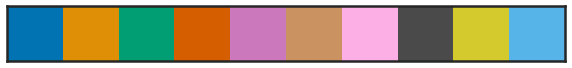

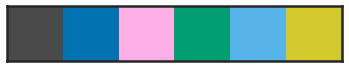

In [272]:
# get seaborn color palette indexed by color names
colors = sns.color_palette('colorblind')
color_names = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'teal']
colors = pd.Series(colors, index=color_names)

# adjust yellow and gray brightness
colors['yellow'] = tuple(0.9 * np.array(colors['yellow']))
colors['gray'] = tuple(0.5 * np.array(colors['gray']))

print(color_names)
sns.palplot(colors)

def hex_code(rgb, lighten=0.0):
    rgb = np.array(rgb)
    rgb = lighten + (1-lighten)*rgb
    rgb = [int(256*v) for v in rgb]
    return '#{:02x}{:02x}{:02x}'.format(*rgb)

print([hex_code(c) for c in colors])
print([hex_code(c, lighten=0.5) for c in colors])

# always use the same method order and colors in figures
method_order = [
    'Real molecule',
    'Real atom types',
    'Real density',
    'AE posterior',
    'VAE posterior',
    'VAE prior',
]
print(method_order)

# adjacent methods are likely to overlap, so want them to contrast
# methods with lower sample variance should be darker, less overlap
# real molecules method has no sample variance at all- use black/gray
# generative methods have sample variance, should be lighter

# select the colors to be assigned to each method in method_order
colors = colors[['gray', 'blue', 'pink', 'green', 'teal', 'yellow']]
sns.palplot(colors)

context = 'poster'
sns.set_palette(colors)
sns.set_style('white')
sns.set_context(context)

if context == 'paper':
    sns.set_context(context)
    fig_h = fig_w = 3
    line_width = 1.5
    vertical = False

if context == 'talk':
    fig_h = fig_w = 5
    line_width = 2
    vertical = False
    
if context == 'poster':
    fig_h = fig_w = 5
    line_width = 2.5
    vertical = False
    sns.set_context(context, font_scale=1.1)

method_order_map = {mtd: i for i, mtd in enumerate(method_order)}
colors_by_method = {mtd: c for mtd, c in zip(method_order, colors)}

paper_df['method_order'] = paper_df['Method'].map(method_order_map.__getitem__)
paper_df = paper_df.sort_values('method_order', kind='mergesort')

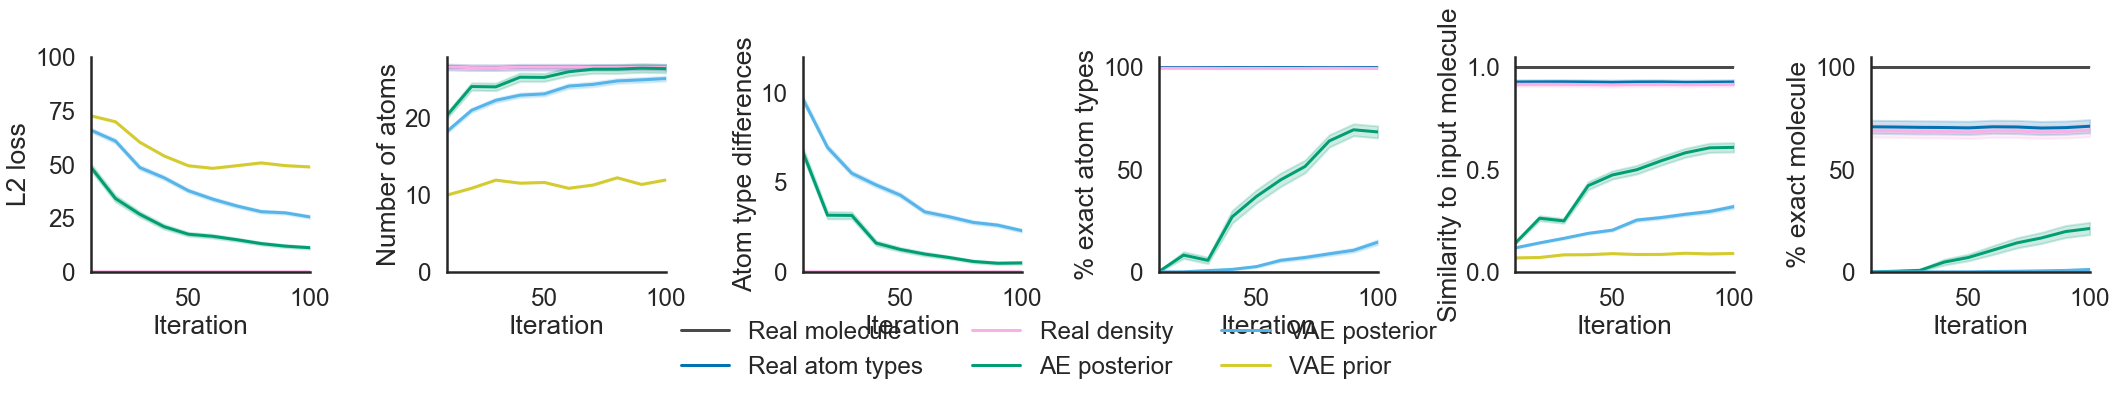

In [301]:
# fit metrics training plot
from results import plot_lines

x = 'Iteration'
y = [
    'L2 loss',
    'Atom type differences',
    '% exact atom types',
    'Number of atoms',
    '% valid coords.',
    'Similarity to input molecule',
    '% exact molecule',
    'QED score'
]
hue = 'Method'

#iter_bin_size = 1
#if iter_bin_size > 1:
#    plot_df['Iteration'] = (plot_df['iteration']//iter_bin_size)*iter_bin_size

plot_df = paper_df[
    paper_df['dataset'] == 'molport'
].groupby([hue, x, 'lig_name'])[y + ['lig_QED']].mean().reset_index()

if context == 'poster':
    plot_df['Iteration'] = (plot_df['Iteration']//1000).astype(int)

    
ylim = [
    (0, 100), (0, 12), (0, 105), (0, 28),
    (0, 105), (0, 1.05), (0, 105), (0.1, 0.8)
]

if context == 'poster':
    yidx = [0, 3, 1, 2, 5, 6]
    y = [y[i] for i in yidx]
    ylim = [ylim[i] for i in yidx]
    n_cols = 6
    center_lgd = True
    lgd_n_cols = 3
    lgd_h = -0.1
else:
    n_cols = 4
    center_lgd = True
    lgd_n_cols = 6
    lgd_h = -0.03

reorder = [0, 3, 1, 4, 2, 5]
_method_order = np.array(method_order)#[reorder]
_colors = np.array(colors)#[reorder]

fig = plot_lines('train_fit_metrics.png', plot_df, x=x, y=y, hue=hue, hue_order=_method_order, colors=_colors,
                  n_cols=n_cols, height=fig_h, width=fig_w, despine=True, lead_x=0, ylim=ylim, alpha=1/5,
                  center_lgd=center_lgd, lgd_title=False, lgd_h=lgd_h, lgd_n_cols=lgd_n_cols, h_pad=1, w_pad=1)

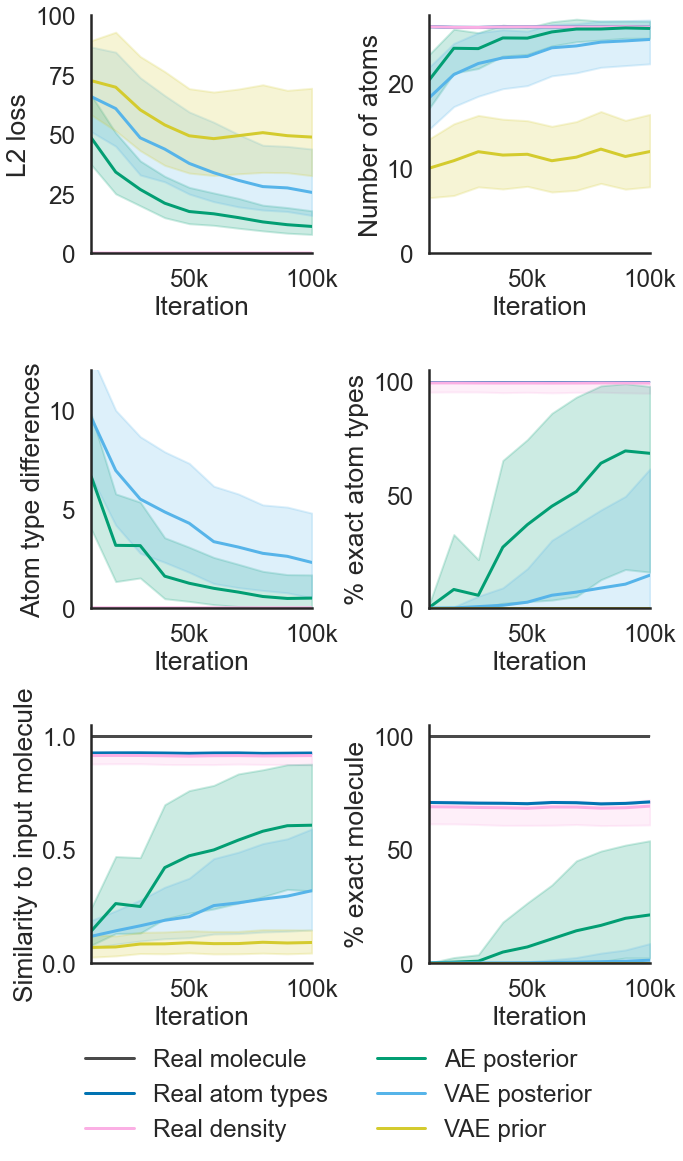

In [315]:
# NOTE the filled in areas are not the standard deviation/standard error
# and they're not the range (i.e. min and max) of the metrics being plotted,
# they are the range of the mean sample metrics- sample min, sample
# mean, and sample max, i.e. the expected sample min, mean and max
#
# for boolean metrics, e.g. lig_gen_fit_add_valid, lig_gen_fit_add_SMILES_match, etc:
# sample MAX  = ANY sample is true
# sample MEAN = FRACTION of samples that are true
# sample MIN  = ALL samples are true

plot2_df = paper_df[
    paper_df['dataset'] == 'molport'
].groupby([hue, x, 'lig_name'])[y + ['lig_QED']].agg(['max', 'mean', 'min']) \
    .groupby([hue, x]).mean().stack().reset_index()

if context == 'poster':
    plot2_df['Iteration'] = (plot2_df['Iteration']//1000).astype(int)
    
reorder = [0, 3, 1, 4, 2, 5]
_method_order = np.array(method_order)#[reorder]
_colors = np.array(colors)#[reorder]

fig = plot_lines('train_fit_metrics2.png', plot2_df, x=x, y=y, hue=hue, hue_order=_method_order, colors=_colors,
                  n_cols=2, height=fig_h, width=fig_w, despine=True, lead_x=0, ylim=ylim, range_=True, alpha=1/5,
                  center_lgd=center_lgd, lgd_title=False, lgd_h=-0.1, lgd_n_cols=2, h_pad=0.5, w_pad=0.5)

if context == 'poster':
    for ax in fig.axes:
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: str(int(x))+'k'))

fig.savefig('train_fit_metrics2.png', bbox_inches='tight', transparent=True)
pd.set_option('display.max_rows', 200)

In [265]:
tab_df = plot2_df.reset_index()
tab_df['Change in QED'] = tab_df['QED score'] - tab_df['lig_QED']
tab_df['method_order'] = tab_df['Method'].map(method_order.index)
tab_df = tab_df.sort_values('method_order')
tab_df[
    tab_df['Iteration'] == 100000
].set_index(['method_order', 'Method', 'Iteration', 'level_2'])

KeyError: 'QED score'

In [54]:
paper_df[
    (paper_df['dataset'] == 'molport') &
    (paper_df['Iteration'] == 100000)
].groupby(['method_order', 'Method', 'Iteration'])[y].mean()

,,,L2 loss,Atom type diff.,% exact atom types,Num. atoms,% valid coords.,Mol. sim. to input,% exact molecule,QED score
method_order,Method,Iteration,,,,,,,,
0,Real molecule,100000,NaN,NaN,NaN,NaN,NaN,1.000000,100.000000,0.654982
1,Real atom types,100000,0.000000,0.000000,100.000000,26.635678,98.115578,0.926802,71.105528,0.661977
2,Real density,100000,0.039670,0.006658,99.359296,26.629774,97.738693,0.915686,69.221106,0.664016
3,AE posterior,100000,11.243974,0.501829,68.323171,26.465244,70.579268,0.608045,21.189024,0.643611
4,VAE posterior,100000,25.563164,2.301005,14.510050,25.170603,22.638191,0.318852,1.193467,0.510385
5,VAE prior,100000,48.832396,21.840025,0.000000,11.968204,0.885287,0.090136,0.000000,0.375189


c:\users\mtr22\code\miniconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


sample_idx  \
Method          Reason for invalid mol.                               
AE posterior    Explicit valence greater than permitted        4915   
                Failed to kekulize molecule                    1476   
                Multiple disconnected fragments                1042   
                No atoms                                        727   
                Valid molecule                                91970   
Real atom types Explicit valence greater than permitted         580   
                Multiple disconnected fragments                 170   
                Valid molecule                                99450   
Real density    Explicit valence greater than permitted         613   
                Failed to kekulize molecule                      31   
                Multiple disconnected fragments                 187   
                Valid molecule                                99369   
Real molecule   Valid molecule                               100200   
VAE posterior   Explicit valence greater than permitted        5287   
                Failed to kekulize molecule                    1828   
                Multiple disconnected fragments                1311   
                No atoms                                        199   
                Valid molecule                                91575   
VAE prior       Explicit valence greater than permitted        5611   
                Multiple disconnected fragments                2697   
                Valid molecule                                91882   

                                                         % of all generated molecules  
Method          Reason for invalid mol.                                                
AE posterior    Explicit valence greater than permitted                      4.908619  
                Failed to kekulize molecule                                  1.474084  
                Multiple disconnected fragments                              1.040647  
                No atoms                                                     0.726056  
                Valid molecule                                              91.850594  
Real atom types Explicit valence greater than permitted                      0.578842  
                Multiple disconnected fragments                              0.169661  
                Valid molecule                                              99.251497  
Real density    Explicit valence greater than permitted                      0.611776  
                Failed to kekulize molecule                                  0.030938  
                Multiple disconnected fragments                              0.186627  
                Valid molecule                                              99.170659  
Real molecule   Valid molecule                                             100.000000  
VAE posterior   Explicit valence greater than permitted                      5.276447  
                Failed to kekulize molecule                                  1.824351  
                Multiple disconnected fragments                              1.308383  
                No atoms                                                     0.198603  
                Valid molecule                                              91.392216  
VAE prior       Explicit valence greater than permitted                      5.600359  
                Multiple disconnected fragments                              2.691885  
                Valid molecule                                              91.707755

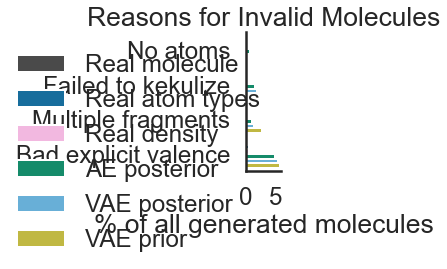

In [275]:
sns.color_palette(colors)

def fix_reason(reason):
    return reason[0].upper() + reason[1:].replace(', ', ' and\n').lower()

plot_df = paper_df[
    (paper_df['iteration'] == 100000) &
    (paper_df['dataset'] == 'pubchem')
]

plot_df['Reason for invalid mol.'] = plot_df['reason'].map(fix_reason)

plot_df = \
    plot_df.groupby(['Method', 'Reason for invalid mol.']) \
    [['sample_idx']].count()

plot_df['% of all generated molecules'] = \
    plot_df / plot_df.groupby(['Method'])[['sample_idx']].agg('sum') * 100

tab_df = plot_df

plot_df = plot_df.reset_index()

reason_order = [
    'Valid molecule',
    'Explicit valence greater than permitted',
    'Multiple disconnected fragments',
    'Failed to kekulize molecule',
    'No atoms',
    'Multiple disconnected fragments and\nexplicit valence greater than permitted',
    'Multiple disconnected fragments and\nfailed to kekulize molecule',
][::-1]
reason_order_map = {rsn: i for i, rsn in enumerate(reason_order)}

plot_df['reason_order'] = plot_df['Reason for invalid mol.'].map(reason_order_map.__getitem__)

abbrev_reason = {
    'Valid molecule': 'Valid',
    'Explicit valence greater than permitted': 'Bad explicit valence',
    'Multiple disconnected fragments': 'Multiple fragments',
    'Multiple disconnected fragments and\nexplicit valence greater than permitted': 'Multiple fragments,\nbad explicit valence',
    'Multiple disconnected fragments and\nfailed to kekulize molecule': 'Multiple fragments,\nfailed to kekulize',
    'Failed to kekulize molecule': 'Failed to kekulize',
    'No atoms': 'No atoms'
}
plot_df['Reason for invalid mol.'] = plot_df['Reason for invalid mol.'].map(abbrev_reason.__getitem__)

plot_df = plot_df.sort_values('reason_order', kind='mergesort')

phi = (1 + np.sqrt(5))/2
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# bar plot of reasons for invalid molecules
sns.barplot(
    x='% of all generated molecules',
    y='Reason for invalid mol.',
    hue='Method',
    hue_order=method_order,
    data=plot_df[plot_df['Reason for invalid mol.'] != 'Valid'],
    ax=ax
)

#ax.set_xlim(0, 20)
ax.legend(loc='upper right', frameon=False, title=None)
ax.set_title('Reasons for Invalid Molecules', fontsize='medium')
#ax.title.set_position([0.5, 1.05])
ax.set_ylabel('')

sns.despine(fig)
fig.tight_layout(rect=[0, 0, 1, 1])
fig.savefig('mol_validity_bars.png')

tab_df

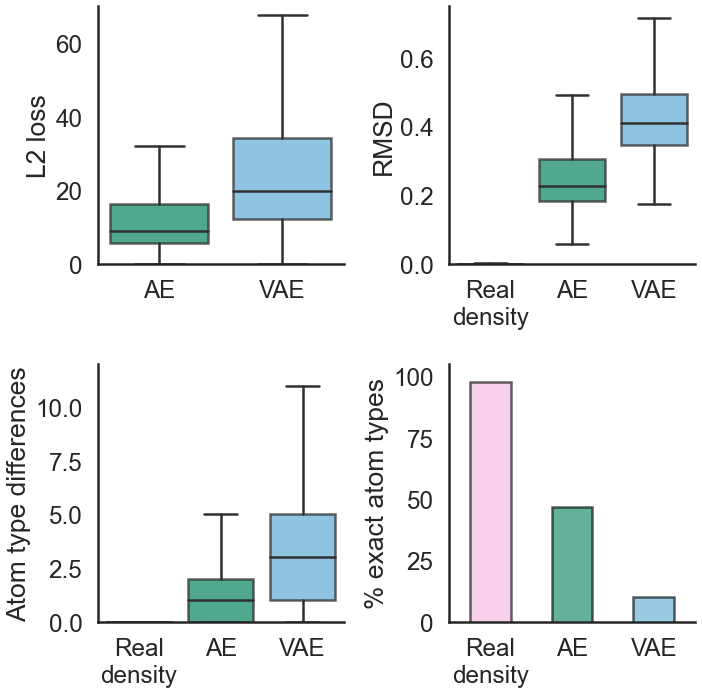

In [278]:
# reconstructing molecules from densities on TEST SET

from results import plot_lines

def fix_bar_plot(ax, alpha=2/3, linewidth=line_width, width=0.5):
    '''
    Make bar plot have a similar style as seaborn box plots.
    '''
    # assumes these are all rectangles
    for p in ax.patches: 
        p.set_alpha(alpha)
        
        # add a dark border
        face_color = p.get_facecolor()
        p.set_edgecolor(0.1*np.array(face_color))
        p.set_linewidth(linewidth)
        
        # hide the lower border
        curr_height = p.get_height()
        p.set_y(p.get_y() - 0.1*curr_height)
        p.set_height(1.1*curr_height)

        # set the bar width
        p.set_x(p.get_x() + (p.get_width()-width) * 0.5)
        p.set_width(width)

# to demonstrate effectivesness of atom fitting on ideal densities,
# show % time we fit exact atom types, then rmsd to true coords (no bonds),
# then % of time we add correct bonds, then rmsd to true molecule

omit_methods = {'Real molecule', 'Real atom types', 'VAE prior'}

plot_df = paper_df[
    (paper_df['iteration'] == 100000) &
    (paper_df['dataset'] == 'pubchem') &
    (~paper_df['Method'].isin(omit_methods))
].copy()

x = 'Mol. sim. to train'
y = [
    'L2 loss',
    'Atom type differences',
    '% exact atom types',
    'RMSD',
]
hue = 'Method'

# line plots mean of sample min, mean, and max wrt test bin
plot2_df = plot_df \
    .groupby([hue, x, 'lig_name'])[y] \
    .agg(['min', 'mean', 'max']) \
    .groupby([hue, x]) \
    .mean().stack().reset_index()

# the previous command changes method order
plot2_df['method_order'] = plot2_df['Method'].map(method_order_map.__getitem__)
plot2_df = plot2_df.sort_values('method_order', kind='mergesort')

_method_order = [m for m in method_order if m not in omit_methods]
_colors = [colors_by_method[m] for m in method_order if m not in omit_methods]

ylim = [
    (0,  70),
    (0,  12),
    (0, 105),
    (0, 0.75),
]

if context == 'poster':
    yidx = [0, 3, 1, 2]
    y = [y[i] for i in yidx]
    ylim = [ylim[i] for i in yidx]
    do_lines = False
else:
    do_lines = True
    
if do_lines: # create extra axes for box/bar plots
    if vertical:
        _y = [yy for yi in y for yy in [None, yi]]
        n_cols = 2
    else:
        _y = [None]*len(y) + y
        n_cols = len(y)

else: # only plot box/bar plots
    _y = [None] * len(y)
    n_cols = 2

fig = plot_lines(
    'atom_fitting_recon.png', plot2_df,
    x=x, y=_y, hue=hue, hue_order=_method_order, colors=_colors, alpha=1/5,
    n_cols=n_cols, height=fig_h, width=fig_w, despine=True, lead_x=0, range_=True,
    center_lgd=True, lgd_title=False, lgd_h=-0.04, lgd_n_cols=4, add_lgd=False, h_pad=2, w_pad=1.5
)
    
abbrev_methods = [
    'Real\nmol.',
    'Real\ntypes',
    'Real\ndensity',
    'AE',
    'VAE',
    'VAE\nprior'
]
plot_df['Method'] = plot_df['method_order'].map(abbrev_methods.__getitem__)



for i, ax in enumerate(fig.axes):
    curr_row = i // n_cols
    curr_col = i % n_cols
    
    if do_lines:
        if vertical:
            curr_y = y[curr_row]
            curr_ylim = ylim[curr_row]
        else:
            curr_y = y[curr_col]
            curr_ylim = ylim[curr_col]
    else:
        curr_y = y[i]
        curr_ylim = ylim[i]

    if not do_lines or (vertical and curr_col == 0) or (not vertical and curr_row == 0): # add bar or box plots 
        
        if curr_y == 'L2 loss':
            curr_plot_df = plot_df[plot_df['Method'] != 'Real\ndensity']
            curr_colors = _colors[1:]
        else:
            curr_plot_df = plot_df
            curr_colors = _colors
        
        if curr_y[0] == '%':
            sns.barplot(
                y=curr_y, x=hue, data=curr_plot_df, ci=None,
                palette=curr_colors, ax=ax
            )
            fix_bar_plot(ax)
        else:
            sns.boxplot(
                y=curr_y, x=hue, data=curr_plot_df,
                boxprops=dict(alpha=0.75), linewidth=line_width, fliersize=0,
                palette=curr_colors, ax=ax
            )

        ax.set_xlabel(None)

    else: # adjust line plot x ticks
        ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
    # standardize y limits for each metric
    ax.set_ylim(curr_ylim)

sns.despine(fig)
fig.savefig('atom_fitting_recon.png', bbox_inches='tight', transparent=True)

In [126]:
# for reporting results, print tables of expected min, mean, and max in 10 samples
plot_df.groupby(['method_order', hue, 'lig_name'])[y].agg(['min', 'mean', 'max']) \
    .groupby(['method_order', hue]).mean().stack()

L2 loss  Atom type diff.  \
method_order Method                                           
2            Real\ndensity min    0.000445         0.046140   
                           mean   0.066302         0.110766   
                           max    0.398802         0.232398   
3            AE\npost.     min    9.253303         1.097873   
                           mean  14.204714         1.937821   
                           max   23.000793         3.330970   
4            VAE\npost.    min   16.674011         2.293718   
                           mean  26.947653         4.146809   
                           max   43.790710         6.474683   

                                 % exact atom types      RMSD  
method_order Method                                            
2            Real\ndensity min            91.221412  0.001601  
                           mean           97.563168  0.011376  
                           max            99.560571  0.043050  
3            AE\npost.     min            13.732148  0.230220  
                           mean           46.555478  0.281767  
                           max            70.058923  0.347488  
4            VAE\npost.    min             0.219714  0.425010  
                           mean           10.107860  0.473801  
                           max            33.726156  0.533019

c:\users\mtr22\code\miniconda3\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\mtr22\code\miniconda3\lib\site-packages\ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\mtr22\code\miniconda3\lib\site-packages\ipykernel_launcher.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

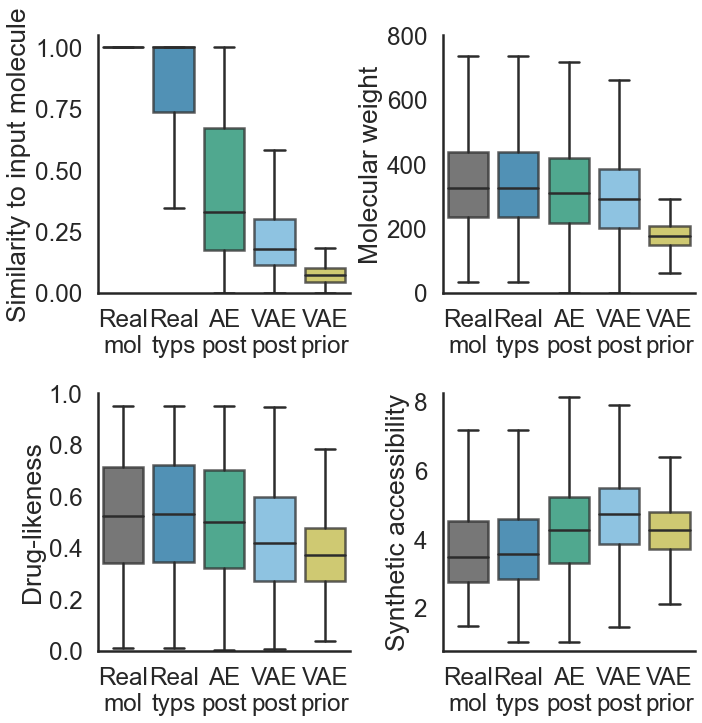

In [281]:
from results import plot_lines
plt.rcParams["axes.axisbelow"] = False

omit_methods = {'Real density'}

plot_df = paper_df[
    (paper_df['iteration'] == 100000) &
    (paper_df['dataset'] == 'pubchem') &
    (~paper_df['Method'].isin(omit_methods))
]

x = 'Similarity to training set'
y = [
    'Similarity to input molecule',
    'Molecular weight',
    'Drug-likeness',
    'Synthetic accessibility',
]
hue = 'Method'

# line plots of sample min, mean, and max wrt test bin
plot2_df = plot_df \
    .groupby([hue, x, 'lig_name'])[y] \
    .agg(['min', 'mean', 'max']) \
    .groupby([hue, x]) \
    .mean().stack().reset_index()

# the previous command changes method order
plot2_df['method_order'] = plot2_df['Method'].map(method_order_map.__getitem__)
plot2_df = plot2_df.sort_values('method_order', kind='mergesort')

_method_order = [m for m in method_order if m not in omit_methods]
_colors = [c for m,c in zip(method_order, colors) if m not in omit_methods]

ylim = [
    (0, 1.05),
    (0, 800),
    (0, 1.0),
    (0.75, 8.25),
]

if context == 'poster':
    n_cols = 2
    lgd_n_cols = 0
    lgd_h = -0.05
    do_lines = False
else:
    do_lines = True
    
if do_lines:
    if vertical:
        _y = [yy for yi in y for yy in [None, yi]]
        n_cols = 2
        lgd_n_cols = 3
        add_lgd = True
    else:
        _y = [None]*len(y) + y
        n_cols = 4
        lgd_n_cols = 6
        add_lgd = True
else:
    _y = [None]*len(y)
    n_cols = 2
    lgd_n_cols = 0
    add_lgd = False

fig = plot_lines(
    'mol_properties.png', plot2_df,
    x=x, y=_y, hue=hue, hue_order=_method_order, colors=_colors, alpha=1/5,
    n_cols=n_cols, height=fig_h, width=fig_w, despine=True, lead_x=0, range_=True,
    center_lgd=True, lgd_title=False, lgd_h=-0.03, lgd_n_cols=lgd_n_cols, add_lgd=add_lgd, w_pad=1, h_pad=2
)

abbrev_methods = [
    'Real\nmol',
    'Real\ntyps',
    'Real\ndens',
    'AE\npost',
    'VAE\npost',
    'VAE\nprior'
]
plot_df['Method'] = plot_df['method_order'].map(abbrev_methods.__getitem__)

#suptitle = fig.suptitle('Properties of Valid Molecules', y=1.075)



for i, ax in enumerate(fig.axes):
    curr_row = i // n_cols
    curr_col = i % n_cols
    
    if do_lines:
        if vertical:
            curr_y = y[curr_row]
            curr_ylim = ylim[curr_row]
        else:
            curr_y = y[curr_col]
            curr_ylim = ylim[curr_col]
    else:
        curr_y = y[i]
        curr_ylim = ylim[i]

    if not do_lines or (vertical and curr_col == 0) or (not vertical and curr_row == 0): # add bar or box plots 
        
        if curr_y[0] == '%':
            sns.barplot(
                y=curr_y, x=hue, data=plot_df, ci=None,
                palette=_colors, ax=ax
            )
            fix_bar_plot(ax)
        else:
            sns.boxplot(
                y=curr_y, x=hue, data=plot_df,
                boxprops=dict(alpha=0.75), linewidth=line_width, fliersize=0,
                palette=_colors, ax=ax
            )

        ax.set_xlabel(None)
        for xtl in ax.get_xticklabels():
            xtl.set_zorder(100)

    else: # adjust line plot x ticks
        ax.set_zorder(0)
        ax.patch.set_visible(False)
        ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
    # standardize y limits for each metric
    ax.set_ylim(curr_ylim)

sns.despine(fig)
fig.savefig('mol_properties.png', bbox_inches='tight', transparent=True)

plot_df['Change in SAS'] = plot_df['SAS'] - plot_df['lig_SAS']
plot_df['Change in QED'] = plot_df['QED'] - plot_df['lig_QED']
y = ['Change in QED', 'Change in SAS']

In [ ]:
# for reporting results, print tables of expected min, mean, and max in 10 samples
plot_df.groupby(['method_order', hue, x, 'lig_name'])[y].agg(['min', 'mean', 'max']) \
    .groupby(['method_order', hue]).mean()

In [60]:
plot_df.groupby(['method_order', hue])[y].mean()

,,Change in QED,Change in SAS
method_order,Method,,
0,Real\nmol.,0.000000,0.000000
1,Real\ntypes,0.003259,0.068089
3,AE\npost.,-0.031236,0.623255
4,VAE\npost.,-0.090138,0.910650
5,VAE\nprior,-0.144560,0.467615


In [61]:
from results import plot_lines

omit_methods = {}

plot_df = paper_df[
    (paper_df['iteration'] == 100000) &
    (paper_df['dataset'] == 'pubchem') &
    (paper_df['has_min_error'] == False) &
    (~paper_df['Method'].isin(omit_methods))
]

x = 'Mol. sim. to train'
y = [
    'ob_logE',
    'ob_min_logE',
    'ob_dlogE_min',
    'ob_RMSD_min',
]
hue = 'Method'

# line plots of sample min, mean, and max wrt test bin
plot2_df = plot_df \
    .groupby([hue, x, 'lig_name'])[y] \
    .agg(['min', 'mean', 'max']) \
    .groupby([hue, x]) \
    .median().stack().reset_index()

# the previous command changes method order
plot2_df['method_order'] = plot2_df['Method'].map(method_order_map.__getitem__)
plot2_df = plot2_df.sort_values('method_order', kind='mergesort')

_method_order = [m for m in method_order if m not in omit_methods]
_colors = [c for m,c in zip(method_order, colors) if m not in omit_methods]

#reorder = range(len(_method_order))
#_method_order = np.array(_method_order)[reorder]
#_colors    = np.array(_colors)[reorder]

_y = [None]*len(y) + y

fig = plot_lines(
    'energy_min.pdf', plot2_df,
    x=x, y=_y, hue=hue, hue_order=_method_order, colors=_colors, alpha=1/5,
    n_cols=len(y), height=3, width=3, despine=True, lead_x=0, range_=True,
    center_lgd=True, lgd_title=False, lgd_h=-0.02, lgd_n_cols=6,
)

abbrev_methods = [
    'Real\nmol.',
    'Real\ntypes',
    'Real\ndens.',
    'AE\npost.',
    'VAE\npost.',
    'VAE\nprior'
]
plot_df['Method'] = plot_df['method_order'].map(abbrev_methods.__getitem__)

#suptitle = fig.suptitle('Properties of Valid Molecules', y=1.075)

ylim = [
    (0, 10),
    (0, 10),
    (-7, 0.7),
    (0, 10),
]

for i, ax in enumerate(fig.axes):
    
    fig_row = i // len(y)
    fig_col = i % len(y)
    curr_y = y[fig_col]

    if fig_row == 0: # add bar or box plots 
        
        if curr_y[0] == '%':
            sns.barplot(
                y=curr_y, x=hue, data=plot_df, ci=None,
                palette=_colors, ax=ax
            )
            fix_bar_plot(ax)
        else:
            sns.boxplot(
                y=curr_y, x=hue, data=plot_df,
                boxprops=dict(alpha=0.75), linewidth=1.5, fliersize=0,
                palette=_colors, ax=ax
            )

        ax.set_xlabel(None)

    else: # adjust line plot x ticks
        ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
    # standardize y limits for each metric
    ax.set_ylim(ylim[fig_col])

sns.despine(fig)
fig.tight_layout()
fig.savefig('energy_min.pdf', bbox_inches='tight') #, extra_artists=[suptitle])

KeyError: "Columns not found: 'ob_logE', 'ob_min_logE', 'ob_dlogE_min'"

In [ ]:
smiles_by_method = dict()

def unique_so_far(row):
    method, smi = row
    if method not in smiles_by_method:
        smiles_by_method[method] = set()
    is_unique = smi not in smiles_by_method[method]
    smiles_by_method[method].add(smi)
    return is_unique

plot_df = paper_df[
    (paper_df['iteration'] == 100000) &
    (paper_df['dataset'] == 'pubchem')
].copy()

plot_df['Valid'] = plot_df['valid']
plot_df['Failed to kekulize'] = plot_df['error_type'].map(lambda x: float('kekulize' in x))
plot_df['Multiple fragments'] = plot_df['error_type'].map(lambda x: float('fragments' in x))
plot_df['Bad valence'] = plot_df['error_type'].map(lambda x: float('valence' in x))

y = '% of molecules'
x = 'Metric'
hue = 'Method'
metrics = ['Valid', 'Bad valence', 'Failed to kekulize']

plot2_df = plot_df.groupby(hue)[metrics].mean() * 100
plot2_df = plot2_df.unstack().reset_index().rename(
        columns={
            0: y,
            'level_0': x
        }
)

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x=x, y=y, hue=hue, hue_order=method_order, data=plot2_df, ax=ax)
fix_bar_plot(ax, width=0.133)

lgd = ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), frameon=False, title=None)
ax.set_ylim(0, 100)
ax.set_xlabel(None)

sns.despine(fig)
fig.tight_layout()
fig.savefig('mol_quality_bars.pdf', bbox_inches='tight', extra_artists=[lgd])
    
plot_df.groupby(['method_order', hue, 'lig_name'])[metrics].agg(['min', 'mean', 'max']) \
    .groupby(['method_order', hue]).mean()

# Latent sampling (3D structure visuals)

In [ ]:
seed = 921343

In [5]:
import matplotlib.image as mpimg
from rdkit import Chem

image_dir = 'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\loss_weights\\fit_pubchem2\\images'


def smi_to_image(smi, align=None, scale=None, rotate=0, flip=False, size=None):

    mol = Chem.MolFromSmiles(smi)
    
    if align is not None:
        ref_mol = Chem.MolFromSmiles(align)
        AllChem.Compute2DCoords(ref_mol)
        AllChem.GenerateDepictionMatching2DStructure(mol, ref_mol)
    else:
        AllChem.Compute2DCoords(mol)

    if flip:
        conf = mol.GetConformer(0)
        for i in range(mol.GetNumAtoms()):
            pos = conf.GetAtomPosition(i)
            pos.x = pos.x
            pos.y = -pos.y
            pos.z = -pos.z
            conf.SetAtomPosition(i, pos)
            
    options = Chem.Draw.MolDrawOptions()
    options.rotate = rotate

    return Chem.Draw.MolToImage(mol, size=size, options=options)


post_df = paper_df[
    (paper_df['dataset'] == 'pubchem') &
    #(paper_df['molport_sim'] > 0.3) & 
    (paper_df['iteration'] == 100000)  &
    (paper_df['variational'] == True) &
    (paper_df['prior'] == False)
].copy()

#mol_df = mol_df[
#    mol_df['lig_fit_add_valid'] & 
#    mol_df['lig_gen_fit_add_valid']
#]
post_df['Change in QED'] = post_df['lig_gen_fit_add_QED'] - post_df['lig_QED']

n_mols = 10
mols = set([
    'PubChem-100732500_0',
    'PubChem-111943229_0',
    'PubChem-116987476_0',
    'PubChem-121846368_0',
    'PubChem-134605733_0',
    'PubChem-4286996_0',
    'PubChem-57261999_0',
    'PubChem-74425007_0',
    'PubChem-76148667_0',
    'PubChem-9819245_0',
])

post_df = post_df[post_df['lig_name'].isin(mols)]
#post_df = post_df[~post_df['Change in QED'].isna()].reset_index()
#post_df = post_df.iloc[post_df.groupby('lig_name')['Change in QED'].idxmax()]
post_df.set_index('lig_name')[['lig_valid', 'lig_QED', 'lig_gen_fit_add_QED', 'Change in QED']]

NameError: name 'paper_df' is not defined

In [ ]:


print(post_df.shape)

prior_df = paper_df[
    (paper_df['dataset'] == 'pubchem') &
    (paper_df['iteration'] == 100000)  &
    (paper_df['variational'] == True) &
    (paper_df['prior'] == True)
].copy()

prior_df = prior_df[prior_df['lig_name'].isin(mols)]
prior_df = prior_df[prior_df['lig_gen_fit_add_valid'] & (~prior_df['lig_gen_fit_add_QED'].isna())].reset_index()
prior_df = prior_df.iloc[pri_df.groupby('lig_name')['lig_gen_fit_add_QED'].idxmax()]

n_methods = 3
n_rows = 3*n_methods # 3D struct, 2D struct, QED for each method
n_cols = n_mols
width = height = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(width*n_cols, height*2.1*n_methods),
                         gridspec_kw=dict(height_ratios=[10, 10, 1]*n_methods))

# apply transforms to align 2D structs to 3D structs
real_flip   = [  0,   0, 0,  0,   0,   1,   0,   0,  0,  0]
real_rotate = [ 30,  30, 0, 30,  45,   5,   0,  15, 30, 45]
post_flip   = [  0,   1, 0,  0,   1,   0,   0,   1,  1,  0]
post_rotate = [210, 180, 0,  0,  30, 185, 180, 175, 30,  0]

for col_idx in range(n_cols):
    
    print(col_idx)
    post_row = mol_df.iloc[col_idx]
    pri_row = pri_df.iloc[col_idx]
    
    for method_idx in range(n_methods):
        
        if method_idx == 0: # real density
            method_name = 'real_density'
            qed = post_row['lig_fit_add_QED']
            smi = post_row['lig_fit_add_SMILES']
            flip = real_flip[col_idx]
            rotate = real_rotate[col_idx]

        elif method_idx == 1: # vae posterior
            method_name = 'vae_posterior'
            qed = post_row['lig_gen_fit_add_QED']
            smi = post_row['lig_gen_fit_add_SMILES']
            flip = post_flip[col_idx]
            rotate = post_rotate[col_idx]
            
        else: # vae prior
            method_name = 'vae_prior'
            qed = pri_row['lig_gen_fit_add_QED']
            smi = pri_row['lig_gen_fit_add_SMILES']
            flip = False
            rotate = 0
  
        im_2d = smi_to_image(smi, flip=flip, rotate=rotate)
        ax = axes[3*method_idx + 1, col_idx]
        ax.imshow(im_2d, aspect='auto')
        
        im_file = os.path.join(image_dir, method_name, 'both' + str(col_idx) + '.png')
        im_3d = mpimg.imread(im_file)
        ax = axes[3*method_idx, col_idx]
        ax.imshow(im_3d, aspect='auto')
        
        ax = axes[3*method_idx + 2, col_idx]
        text = 'QED = {:.2f}'.format(qed)
        
        if method_name == 'vae_posterior':
            qed_imp = qed - row['lig_QED']
            text += ' ({}{:.2f})'.format(['', '+'][qed_imp>0], qed_imp)
            
        ax.text(0.5, 1.0, text,
            transform=ax.transAxes, 
            horizontalalignment='center',
            verticalalignment='center',
            fontsize='x-large',
            zorder=100,
        )

for ax in axes.flatten():
    ax.set_xticklabels([])
    ax.set_yticklabels([])

axes[0,0].set_ylabel('Random input molecule', fontsize='x-large')
axes[3,0].set_ylabel('Most drug-like output molecule', fontsize='x-large')
axes[6,0].set_ylabel('Random drug-like prior molecule', fontsize='x-large')
axes[0,0].yaxis.set_label_coords(-0.1, 0.0)
axes[3,0].yaxis.set_label_coords(-0.1, 0.0)
axes[6,0].yaxis.set_label_coords(-0.1, 0.0)

sns.despine(fig, top=True, bottom=True, left=True, right=True)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('vae_post_mols2.pdf', bbox_inches='tight')
os.getcwd()

In [ ]:
from rdkit.Chem import AllChem
import rdkit.Geometry

i = 1
lig_smi = mol_df.iloc[i]['lig_SMILES']
lig_fit_add_smi = mol_df.iloc[i]['lig_fit_add_SMILES']
lig_gen_fit_add_smi = mol_df.iloc[i]['lig_gen_fit_add_SMILES']
print(lig_smi)
print(lig_fit_add_smi)
print(lig_gen_fit_add_smi)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].imshow(smi_to_image(lig_smi))
axes[1].imshow(smi_to_image(lig_gen_fit_add_smi))
axes[2].imshow(smi_to_image(lig_gen_fit_add_smi, flip=1, rotate=180))

for ax in axes.flatten():
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
sns.despine(fig, bottom=True, top=True, right=True, left=True)

In [ ]:
coords_dir = 'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\loss_weights\\fit_pubchem2'

def get_3d_coords(row, struct_type):
    job_name, lig_name, sample_idx, array_idx = row
    struct_file = os.path.join(
        coords_dir,
        job_name,
        '{}_{}_{}_{}_{}.sdf'.format(job_name, array_idx, lig_name, struct_type, sample_idx)
    )
    return next(Chem.SDMolSupplier(struct_file))

mol_df['lig_mol'] = mol_df[['job_name', 'lig_name', 'sample_idx', 'array_idx']].apply(get_3d_coords, struct_type='lig_add', axis=1)
mol_df['lig_mol']

In [ ]:
seed

In [ ]:
#seed = int(np.random.rand() * 1000000) # 251911 921343

# Latent interpolation

In [ ]:
lat_df = fit_df[
    (fit_df['dataset'] == 'molport') &
    (fit_df['iteration'] == 100000)  &
    (fit_df['variational'] == False) &
    (fit_df['prior'] == False)
]
lat_df.sort_values('lig_gen_fit_add_QED', ascending=False)

In [ ]:
lat_df = fit_df[(fit_df['dataset'] == 'molport') &
                (fit_df['iteration'] == 100000)  &
                (fit_df['variational'] == True) &
                (fit_df['prior'] == False)]

lat_df.sort_values('lig_gen_fit_add_QED', ascending=False)

In [ ]:
interp_dir = 'C:\\Users\\mtr22\\Code\\liGAN\\train_molport\\loss_weights'

interp_metrics_files = [
    'pose_interp\\pose_interp.gen_metrics',
    'latent_interp\\latent_interp.gen_metrics',
]

pose_interp_job_name_format = 'pose_interp_{}'
latent_interp_job_name_format = 'latent_interp_{}'

def parse_interp_job_name(job_name):
    pass

interp_dfs = []
for i, interp_metrics_file in enumerate(interp_metrics_files):
    interp_df = pd.read_csv(os.path.join(interp_dir, interp_metrics_file), sep=' ')
    interp_df['expt_name'] = os.path.dirname(interp_metrics_file)
    interp_dfs.append(interp_df)

interp_df = pd.concat(interp_dfs)
interp_df.groupby(['job_name', 'lig_name'])[['array_idx']].count()

In [ ]:
interp_df['job_name'].unique()

In [ ]:
interp_df = interp_df.set_index(['job_name', 'lig_name', 'sample_idx'])
interp_df

pose_interp/images/pose_interp_ae_disc_x_ri_pose_interp_rand/2054212_1_to_2054212_2


NameError: name 'interp_dir' is not defined

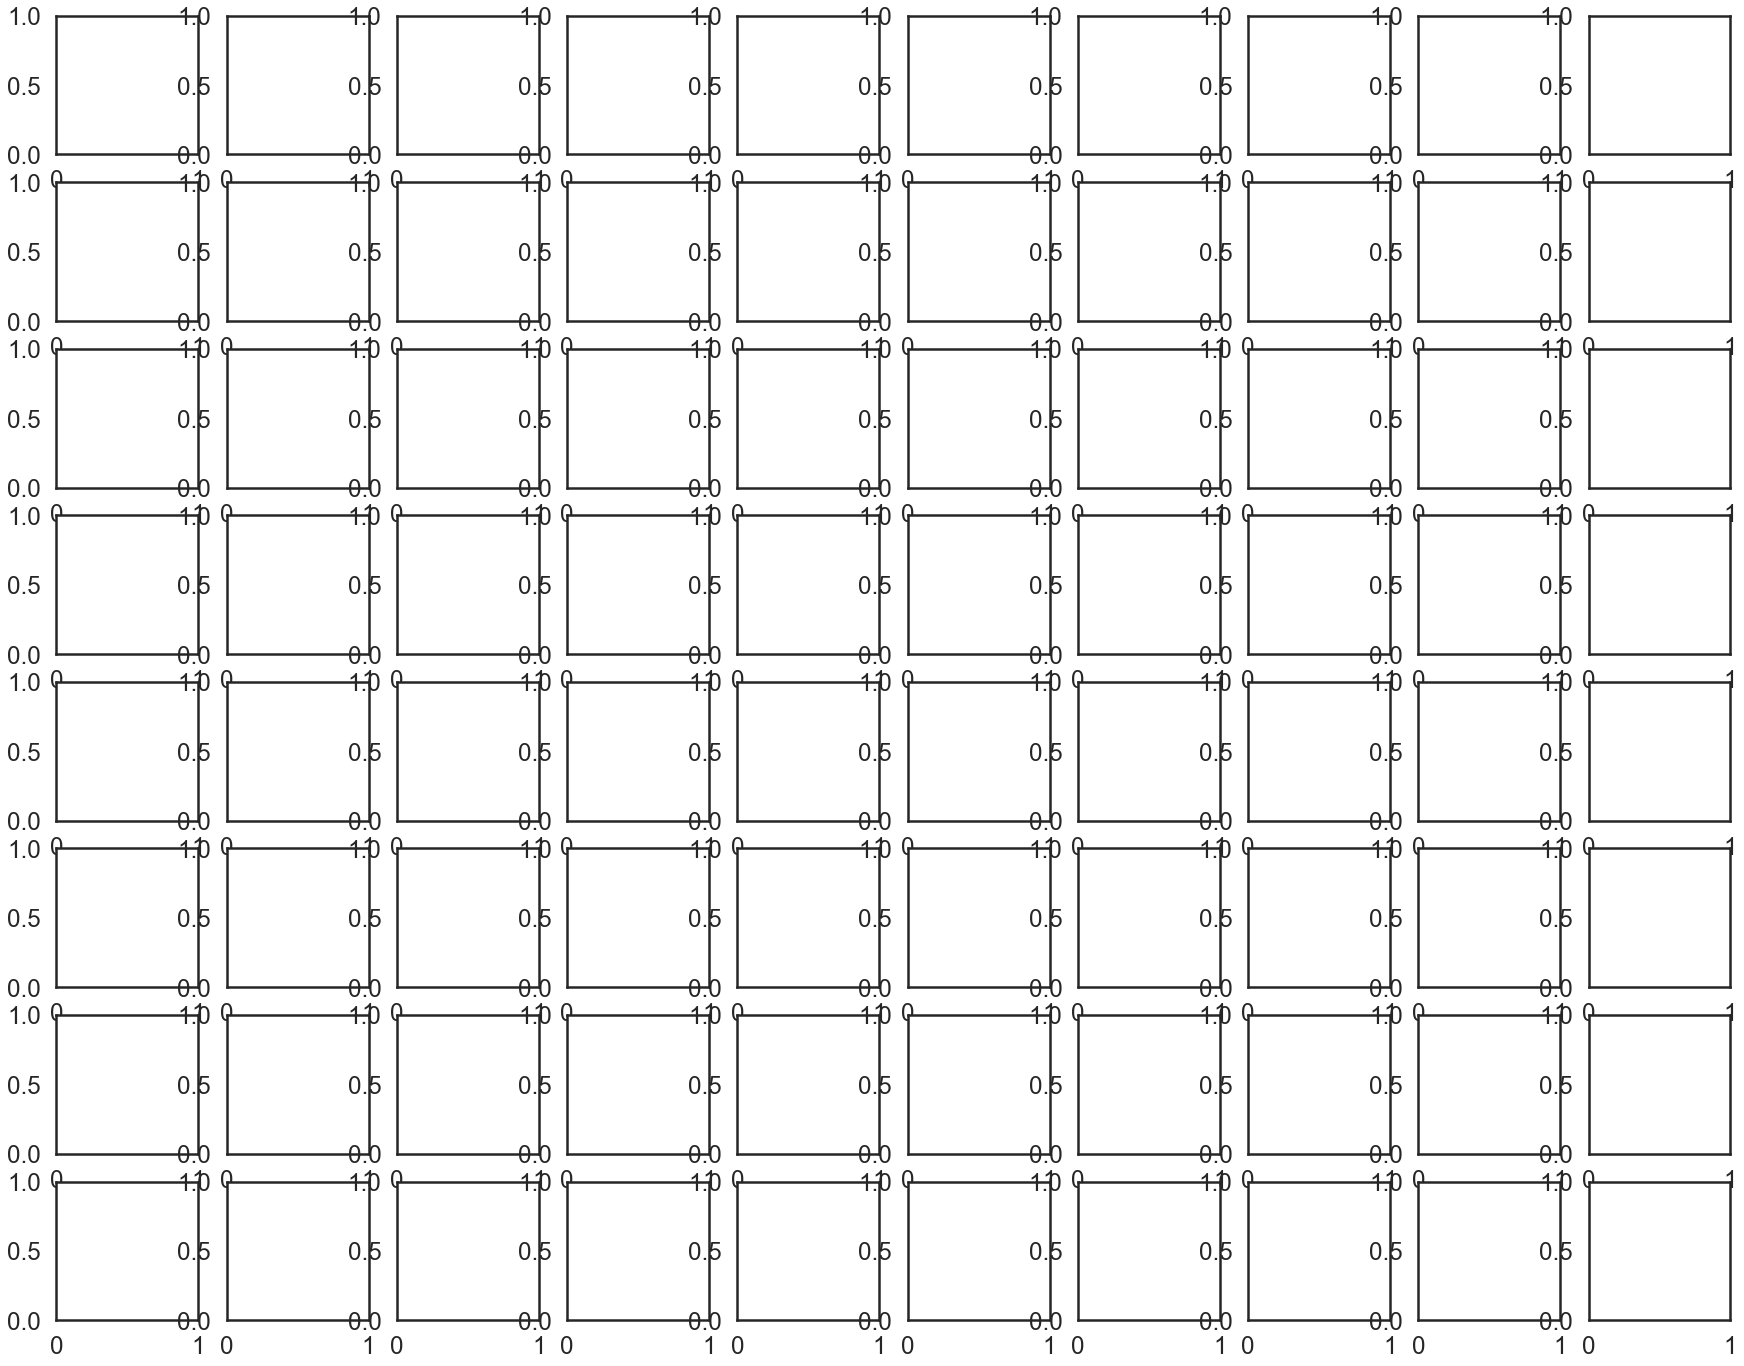

In [291]:
import matplotlib.image as mpimg

def smi_to_image(smi):
    mol = Chem.MolFromSmiles(smi)
    return Chem.Draw.MolToImage(mol)

image_dirs = [
    #'pose_interp/images/pose_interp_ae_disc_x_ri_pose_interp_rand/2054212_13_to_2054212_12',
    #'pose_interp/images/pose_interp_ae_disc_x_ri_pose_interp_rand/2054212_14_to_2054212_11',
    'pose_interp/images/pose_interp_ae_disc_x_ri_pose_interp_rand/2054212_1_to_2054212_2',
    #'pose_interp/images/pose_interp_ae_disc_x_ri_pose_interp_rand/2054212_9_to_2054212_10',
    
    #'pose_interp/images/pose_interp_gen_e_0.1_1_disc_x_10_rsi_pose_interp2_rand/743176_10_to_743176_8',
    'pose_interp/images/pose_interp_gen_e_0.1_1_disc_x_10_rsi_pose_interp2_rand/743176_12_to_743176_6',
    #'pose_interp/images/pose_interp_gen_e_0.1_1_disc_x_10_rsi_pose_interp2_rand/743176_13_to_743176_5',
    #'pose_interp/images/pose_interp_gen_e_0.1_1_disc_x_10_rsi_pose_interp2_rand/743176_4_to_743176_9',
    
    #'latent_interp/images/latent_interp_ae_disc_x_ri_pubchem_diff0.5_head_10/PubChem-118526673_0_to_PubChem-118185755_0',
    #'latent_interp/images/latent_interp_ae_disc_x_ri_pubchem_diff0.5_head_10/PubChem-18984741_0_to_PubChem-10493075_0',
    'latent_interp/images/latent_interp_ae_disc_x_ri_pubchem_diff0.5_head_10/PubChem-6483245_0_to_PubChem-123732546_0',
    #'latent_interp/images/latent_interp_ae_disc_x_ri_pubchem_diff0.5_head_10/PubChem-93620749_0_to_PubChem-115114367_0',
    
    'latent_interp/images/latent_interp_gen_e_0.1_1_disc_x_10_rsi_pubchem_diff0.5_head_10/PubChem-118526673_0_to_PubChem-118185755_0',
    #'latent_interp/images/latent_interp_gen_e_0.1_1_disc_x_10_rsi_pubchem_diff0.5_head_10/PubChem-18984741_0_to_PubChem-10493075_0',
    #'latent_interp/images/latent_interp_gen_e_0.1_1_disc_x_10_rsi_pubchem_diff0.5_head_10/PubChem-6483245_0_to_PubChem-123732546_0',
    #'latent_interp/images/latent_interp_gen_e_0.1_1_disc_x_10_rsi_pubchem_diff0.5_head_10/PubChem-93620749_0_to_PubChem-115114367_0',
]

#interp_mask = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] # full interpolation
interp_mask = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1] # slow at end points, fast in middle
#interp_mask = [1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1] # fast at end points, slow in middle
interp_idxs = [i+1 for i in range(20) if interp_mask[i]]

n_rows = 2*len(image_dirs)
n_cols = len(interp_idxs)
width = height = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(width*n_cols, height*n_rows))

for row_idx, image_dir in enumerate(image_dirs):
    print(image_dir)
    for col_idx, interp_idx in enumerate(interp_idxs):
        
        lig_idx = (interp_idx - 1)//10 # n_samples = 10
        sample_idx = (interp_idx - 1)%10
        
        parent_dir, lig_names = os.path.split(image_dir)
        lig_name = re.split('_to_', lig_names)[lig_idx]
        parent_dir, job_name = os.path.split(parent_dir)
        
        ax = axes[2*row_idx, col_idx]
        im_file = os.path.join(interp_dir, image_dir, 'both' + str(interp_idx).zfill(4) + '.png')
        im = mpimg.imread(im_file)
        ax.imshow(im, aspect='auto')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    
        ax = axes[2*row_idx + 1, col_idx]
        lig_smiles = interp_df.loc[job_name, lig_name, sample_idx]['lig_gen_fit_add_SMILES']
        try:
            im = smi_to_image(lig_smiles)
            ax.imshow(im, aspect='auto')
        except ValueError:
            pass
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
axes[0,0].set_ylabel('AE pose interpolation', fontsize='x-large')
axes[2,0].set_ylabel('VAE pose interpolation', fontsize='x-large')
axes[4,0].set_ylabel('AE molecule interpolation', fontsize='x-large')
axes[6,0].set_ylabel('VAE molecule interpolation', fontsize='x-large')

axes[0,0].yaxis.set_label_coords(-0.1, 0.0)
axes[2,0].yaxis.set_label_coords(-0.1, 0.0)
axes[4,0].yaxis.set_label_coords(-0.1, 0.0)
axes[6,0].yaxis.set_label_coords(-0.1, 0.0)
    
sns.despine(fig, top=True, bottom=True, left=True, right=True)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('latent_interp2.png', bbox_inches='tight')
os.getcwd()

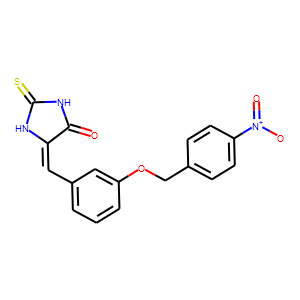

In [293]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

smi = 'O=C1NC(=S)N/C1=C/c1cccc(OCc2ccc([N+](=O)[O-])cc2)c1'
mol = Chem.MolFromSmiles(smi)
Chem.Draw.MolToImage(mol, dpi=300)